# Batch norm sur un modèle simple avec sigmoïde
Réseau de neurones à 2 couches. Comparaison entre une option avec batch norm et une option sans.

In [1]:
# Xv
# ooo ... ooo    L1 : 100 neurons fully connected layer + Batch norm + Sigmoid
#    o...o       L2 :   10 neurons fully connected layer + softmax
# Y


Epoque: 
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  

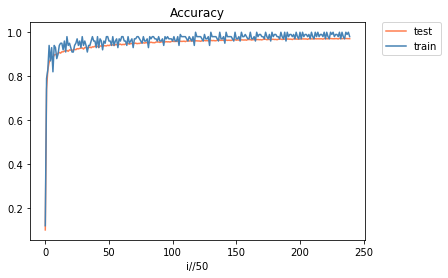

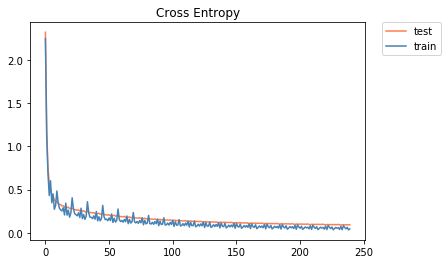

Best score for iteration 11550 	| Accuracy = 0.9721


In [9]:
from __future__ import print_function
import logging 
logging.getLogger('tensorflow').disabled = True # Suppression des warnings
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.python.ops import math_ops

# Hyper parameters
n_epoch = 20
batch_size = 100
learning_rate = 0.003


def batch_norm_sigmoid(Ylogits, Scale, Offset):
    mean, variance = tf.nn.moments(Ylogits, [0])
    Yhat = (Ylogits - mean)/tf.sqrt(variance + 1e-5)
    Ybn  = Scale * Yhat + Offset
    return tf.nn.sigmoid(Ybn)


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255.
x_test  = x_test/255.
y_train = to_categorical(y_train, dtype='int8')
y_test  = to_categorical(y_test, dtype='int8')

train_size = x_train.shape[0]
test_size  = x_test.shape[0]


X = tf.placeholder(tf.float32, shape=(None,28,28))
Xv = tf.reshape(X, [-1, 784])

W1 = tf.Variable(tf.truncated_normal([784,100], stddev=0.1))
b1 = tf.Variable(tf.zeros([100]))
Yl1 = tf.matmul(Xv,W1) + b1

S1     = tf.Variable(tf.ones([100]))
O1     = tf.Variable(tf.zeros([100]))
m1, v1 = tf.nn.moments(Yl1, axes=[0])


#Y1   = batch_norm_sigmoid(Yl1, S1, O1)
Y1   = tf.nn.sigmoid(Yl1)


#Y1    = tf.nn.sigmoid(Ybn1)

W2 = tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))
b2 = tf.Variable(tf.zeros([10]))
Ylogits = tf.matmul(Y1,W2) + b2
Y = tf.nn.softmax(Ylogits)

Y_ = tf.placeholder(tf.float32, shape=(None,10))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_sum(cross_entropy)

is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

# Optimisation
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)


accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
i_best = 0
accuracy_best = 0

sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
print('Epoque: ')

for i in range(n_epoch*train_size//100):
    epoch = (i*100)//train_size + 1
    
    # Chargement d'un batch d'images et de réponses correctes correspondantes
    batch_train_X  = x_train[(i*100)%train_size:((i+1)*100)%train_size]
    batch_train_Y_ = y_train[(i*100)%train_size:((i+1)*100)%train_size]
    # Dictionnaire de données en entrée
    train_data = {X: batch_train_X, Y_: batch_train_Y_}

    # train
    sess.run(train_step, feed_dict=train_data)
    
    # Visualisation de la progression
    if not (i*100)%(train_size):
        #Affichage de l'évolution en ligne
        print(epoch, ' ', end='')
    if not i%50:
        # Pour le batch d'entraînement
        acc, loss  = sess.run([accuracy, cross_entropy], feed_dict=train_data)
        accuracy_train.append(acc)
        loss_train.append(loss/batch_size)
        
        # Pour le test: évaluation sur tout l'ensemble des données
        
        test_data = {X: x_test, Y_: y_test}
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
        accuracy_test.append(acc)
        loss_test.append(loss/test_size)
        if acc>accuracy_best:
            accuracy_best = acc
            i_best = i
        

# Représentation des résultats
# Précision
plt.plot(accuracy_test, c='coral', label='test')
plt.plot(accuracy_train, c='steelblue', label='train')
plt.xlabel('i//50')
plt.title('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Fonction de coût
plt.plot(loss_test, c='coral', label='test')
plt.plot(loss_train, c='steelblue', label='train')
plt.title('Cross Entropy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Meilleur résultat sur un batch de test
print("Best score for iteration {} \t| Accuracy = {:.4f}".format(i_best, accuracy_best ))

sess.close()

Sans BN: Best score for iteration 11550 	| Accuracy = 0.9691
